In [3]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [4]:
# set random seed for reproducibility
np.random.seed(12345)

x = np.arange(5,400,10)*1e3

# Parameters for gaussian
amp_true = 0.2
size_true = 1.8
ps_true = 0.1

# Gaussian function
gauss = lambda x,amp,size,ps: amp*np.exp(-1*(np.pi**2/(3600.*180.)*size*x)**2/(4.*np.log(2.)))+ps
f_true = gauss(x=x,amp=amp_true, size=size_true, ps=ps_true )

# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
f = f_true + noise 
f_error = np.ones_like(f_true)*0.05*f.max()

In [5]:
# define the model/function to be fitted.
def model(x, f): 
    amp = pm.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pm.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pm.Normal('ps', 0.13, 40, value=0.15)

    @pm.deterministic(plot=False)
    def gauss(x=x, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pm.MCMC(model(x,f))
MDL.sample(20000, 10000, 1)

 [-----------------100%-----------------] 20000 of 20000 complete in 4.9 sec

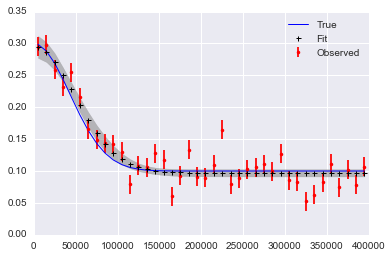

In [6]:
# extract and plot results
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

Plotting ps
Plotting amp
Plotting size


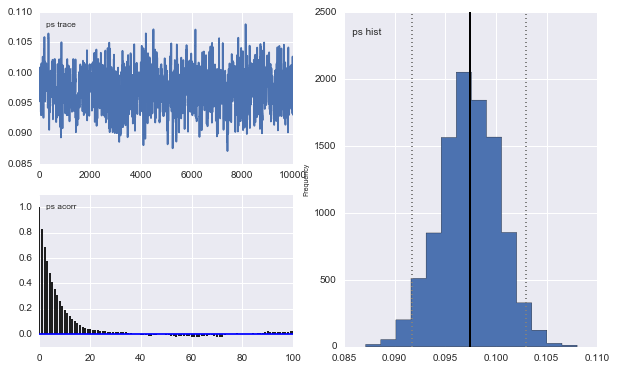

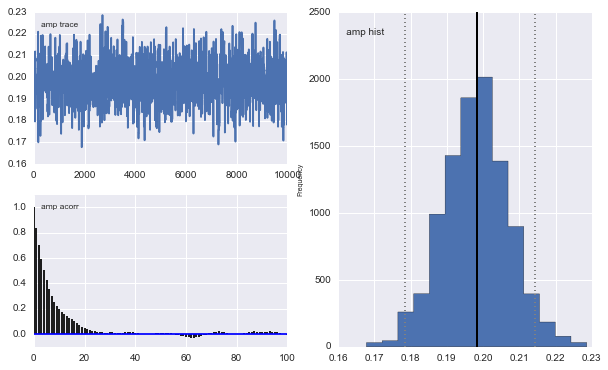

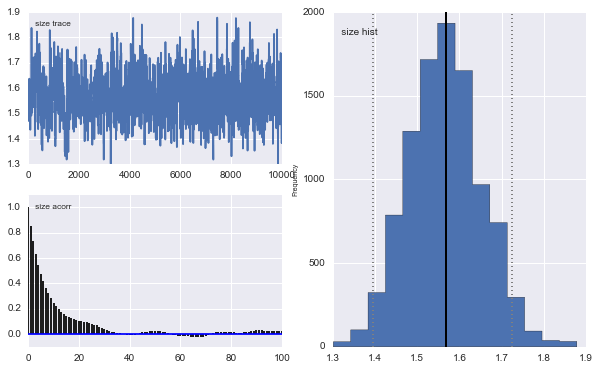

In [7]:
pm.Matplot.plot(MDL)

In [8]:
MDL.summary()


ps:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.097            0.003            0.0              [ 0.092  0.103]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.091            0.096           0.097          0.099         0.103
	

gauss:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.294            0.009            0.0              [ 0.277  0.312]
	0.286            0.008            0.0              [ 0.271  0.302]
	0.271            0.007            0.0              [ 0.257  0.284]
	0.251            0.006            0.0              [ 0.24   0.262]
	0.228            0.005            0.0              [ 0.217  0.238]
	0.204            0.006            0.0              [ 0.193  0.215]

In [9]:
# add noise to observed x values
x_obs = pm.rnormal(mu=x, tau=(1e4)**-2)

# define the model/function to be fitted.
def model(x_obs, f): 
    amp = pm.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pm.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pm.Normal('ps', 0.13, 40, value=0.15)
    
    x_pred = pm.Normal('x', mu=x_obs, tau=(1e4)**-2) # this allows error in x_obs

    @pm.deterministic(plot=False)
    def gauss(x=x_pred, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pm.MCMC(model(x_obs, f))
MDL.use_step_method(pm.AdaptiveMetropolis, MDL.x_pred) # use AdaptiveMetropolis to "learn" how to step
MDL.sample(200000, 100000, 10)  # run chain longer since there are more dimensions

 [-----------------100%-----------------] 200000 of 200000 complete in 89.0 sec

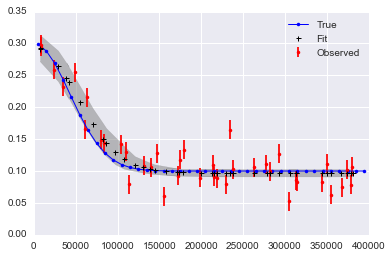

In [10]:
# extract and plot results
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
x_fit = MDL.x_pred.trace().mean(0)
plt.plot(x,f_true,'b', marker='.', ls='-', lw=1, label='True')
plt.errorbar(x_obs, f, yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x_fit,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(x_fit, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

In [11]:
MDL.summary()


x:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	7444.386         9254.662         377.47   [-11798.328  23934.555]
	7032.066         8769.971         351.353  [-10460.73   23691.883]
	28907.085        7120.745         275.268  [ 14669.388  42408.876]
	41561.333        6123.307         221.651  [ 29601.917  53536.855]
	38914.423        6005.117         213.071  [ 27314.761  50531.568]
	54968.324        6003.908         214.205  [ 42879.852  66633.494]
	70299.424        6491.317         206.937  [ 58219.178  83524.939]
	82532.932        7211.969         256.211  [ 68992.182  97175.034]
	86378.13         7391.839         287.809[  72553.668  101505.711]
	97308.807        8651.233         324.904[  81032.085  115123.547]
	107770.468       9039.511         353.319[  90431.137  125450.358]
	120552.074       8595.201         368.501[ 103577.416  137843.68 ]
	130729.743       9385.634         337.374